In [2]:
import os
import json
import traceback
import pandas as pd
from sqlalchemy import create_engine, types
from typing import Annotated, List, Sequence, Tuple, Union, Optional, Literal
from typing_extensions import TypedDict

from pydantic import BaseModel, Field

# LangChain / LangGraph Imports
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.tools import tool

from langchain_ollama import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit

from langchain.agents import initialize_agent, AgentType
from langchain.tools import DuckDuckGoSearchRun

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.types import Command

import re
import psycopg2

In [3]:
# --- Database, LLM, Embeddings, Weaviate Setup ---
# (Keep the setup code exactly as in the previous version)
# --- Database Setup ---
user = os.getenv("DB_USER", "aitheuser1")
password = os.getenv("DB_PASSWORD", "aithepwd8#")
host = os.getenv("DB_HOST", "192.168.1.204")
port = os.getenv("DB_PORT", "55432")
database = os.getenv("DB_NAME", "skku")
# t2t_poc 스키마를 기본 검색 경로로 설정, %3D는 '='의 URL 인코딩
db_uri = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}?options=-csearch_path%3Dm_asset"
try:
    engine = create_engine(db_uri, echo=False)
    db = SQLDatabase(engine=engine)
    print(f"DB Connected. Dialect: {db.dialect}. Tables: {db.get_usable_table_names()}")    
except Exception as e:
    print(f"Error connecting to database: {e}")
    exit()

DB Connected. Dialect: postgresql. Tables: ['daily_trade_execution_data', 'exchange_kosdaq_stock_master', 'exchange_kosdaq_stock_master_01', 'industry_stock_mapping', 'kosdaq_stock_batch', 'kosdaq_trade_execution', 'kospi_stock_batch', 'kospi_trade_execution', 'securities_stock_info_kosdaq', 'securities_stock_info_kospi', 'trade_status']


In [4]:
# --- LLM & Embeddings Setup ---
ollama_base_url = "http://192.168.1.203:11434"
try:
    ollama_embeddings = OllamaEmbeddings(base_url=ollama_base_url, model="bge-m3:latest")
    #_ = ollama_embeddings.embed_query("test")
    print("Embeddings connection successful.")
except Exception as e:
    print(f"Error initializing Ollama Embeddings: {e}")
    exit()

Embeddings connection successful.


C:\Users\kevin\AppData\Local\Temp\ipykernel_5724\1742151902.py:4: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  ollama_embeddings = OllamaEmbeddings(base_url=ollama_base_url, model="bge-m3:latest")


In [1]:
# llm = ChatOllama(model="llama3.2:latest", temperature=0, base_url=ollama_base_url)

from langchain_openai import OpenAI  # ChatOpenAI 대신 OpenAI 사용

server_url = "http://192.168.1.239/vllm9/v1"
# model_name = "omnisql-32b"
# model_name = "qwencoder-32b"        # XGenerationLab/XiYanSQL-QwenCoder-32B-2504
model_name = "qwen2_5-32b"        # Qwen/Qwen2.5-32B

# OpenAI 클래스는 /completions 엔드포인트를 사용
t2s_llm = OpenAI(
    model=model_name,
    openai_api_key="EMPTY",
    openai_api_base=server_url,
    temperature=0
)

In [5]:
# --- Weaviate Setup ---
import weaviate
from weaviate.classes.config import Property, DataType
client = weaviate.connect_to_local(host="192.168.1.203", port=8585)
news_collection_schema = client.collections.get("m_asset_hybrid_1")
# news_collection_sample = client.collections.get("m_asset_sample_query_1")     # 정확한 쿼리 제공 Weaviate_sample_query_masset1.ipynb
news_collection_sample = client.collections.get("m_asset_sample_query_2_hint")   # 힌트 쿼리 제공 Weaviate_sample_query_masset2.ipynb

In [6]:
from langfuse import Langfuse

langfuse = Langfuse(
  secret_key="sk-lf-14dc9542-fc0c-48c9-a742-fffcd90eea8c",
  public_key="pk-lf-f8bcdf8f-21e4-4cb6-87bf-7dae7741b8d5",
  host="https://us.cloud.langfuse.com"
)

In [7]:
from langfuse.langchain import CallbackHandler
 
# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

### Text to SQL Sub Graph 

In [ ]:
# --- SQL Toolkit Setup ---
toolkit = SQLDatabaseToolkit(db=db, llm=t2s_llm)
tools = toolkit.get_tools()
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
query_sql_tool = next(tool for tool in tools if tool.name == "sql_db_query")
query_checker_tool = next(tool for tool in tools if tool.name == "sql_db_query_checker")

class TextToSqlState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    retrieved_schema_examples: List[str]
    retrieved_sample_query: List[str]
    relevant_tables: List[str]
    table_schema: str
    final_query: str
    error_message: Optional[str]
    query_result: str
    retry_count: int

def get_initial_user_query(state: TextToSqlState) -> str:
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            return msg.content
    return ""

# Synchronous Nodes
def get_schema_from_vector_db(state: TextToSqlState):
    if news_collection_schema is None:
        print("--- [TextToSql] Vector DB collection not available. Skipping schema retrieval. ---")
        return {"retrieved_schema_examples": [], "error_message": None}
    user_query = get_initial_user_query(state)
    if not user_query: return {"retrieved_schema_examples": [], "error_message": None}
    # print(f"--- [TextToSql] Querying Vector DB for: '{user_query}' ---")
    try:
        embedded_query = ollama_embeddings.embed_query(user_query)
        results = news_collection_schema.query.hybrid(
            query=user_query,
            vector=embedded_query,  # 벡터도 함께 제공
            alpha=0.5,
            # max_vector_distance=0.2, # max accepted distance - threshold
            limit=3,
            return_properties=["query", "type_name", "explanation", "search_content"], # type: ignore
        )

        retrieved_examples_list = []
        message_content = "Vector DB schema Search Results:\n"
        if not results.objects: message_content += "No relevant schema found."
        else:
            for i, obj in enumerate(results.objects):
                sql_example = obj.properties.get("query")
                if sql_example:
                    retrieved_examples_list.append(str(sql_example)) # Ensure string
                    type_name = obj.properties.get("type_name", "N/A")
                    explanation = obj.properties.get("explanation", "N/A")
                    search_content_retrieved = obj.properties.get("search_content", "N/A") # For debugging/inspection
                    
                    message_content += (
                        f"\n--- Example {i+1} (Type: {type_name}) ---\n"
                        f"Explanation: {explanation}\n"
                        f"Search Content Used (for debugging): {search_content_retrieved}\n" # Show what was embedded
                        f"```sql\n{sql_example}\n```"
                    )
        # print(f"Found {len(retrieved_examples_list)} SQL examples in Vector DB.")
        return {
            **state,
            "messages": [AIMessage(content=message_content)],
            "retrieved_schema_examples": retrieved_examples_list,
            "error_message": None
        }
    except Exception as e:
        print(f"Error during vector DB query: {e}")
        traceback.print_exc()
        return {"messages": [AIMessage(content=f"Warning: Vector DB query failed. {e}")], "retrieved_sql_examples": [], "error_message": None}
    
def get_sample_query_from_vector_db(state: TextToSqlState):
    if news_collection_sample is None:
        print("--- [TextToSql] Vector DB collection not available. Skipping samples retrieval. ---")
        return {"retrieved_sql_examples": [], "error_message": None}
    user_query = get_initial_user_query(state)
    if not user_query: return {"retrieved_sql_samples": [], "error_message": None}
    print(f"--- [TextToSql] Querying Vector DB(sample_query) for: '{user_query}' ---")
    try:
        embedded_query = ollama_embeddings.embed_query(user_query)
        results = news_collection_sample.query.hybrid(
            query=user_query,
            vector=embedded_query,  # 벡터도 함께 제공
            alpha=0.5,
            max_vector_distance=0.5, # max accepted distance - threshold
            limit=2,
            # return_properties=["query", "type_name", "explanation"], # type: ignore
            return_properties=["query", "explanation"], # type: ignore
        )

        retrieved_examples_list = []
        message_content = "Vector DB sample_query Search Results:\n"
        if not results.objects: message_content += "No relevant samples found."
        else:
            for i, obj in enumerate(results.objects):
                sql_example = obj.properties.get("query")
                if sql_example:
                    retrieved_examples_list.append(str(sql_example)) # Ensure string
                    # type_name = obj.properties.get("type_name", "N/A")
                    explanation = obj.properties.get("explanation", "N/A")
                    
                    message_content += (
                        # f"\n--- Example {i+1} (Type: {type_name}) ---\n"
                        f"\n--- Example {i+1} ---\n"
                        f"Explanation: {explanation}\n"
                        f"```sql\n{sql_example}\n```"
                    )
        print(f"Found {len(retrieved_examples_list)} SQL examples in Vector DB.")
        return {
            **state,
            "messages": [AIMessage(content=message_content)],
            "retrieved_sample_query": retrieved_examples_list,
            "error_message": None
        }
    except Exception as e:
        print(f"Error during vector DB query: {e}")
        traceback.print_exc()
        return {"messages": [AIMessage(content=f"Warning: Vector DB query failed. {e}")], "retrieved_sql_examples": [], "error_message": None}

def generate_sql_query_with_schema(state: TextToSqlState):
    # llm_sql_gen = ChatOllama(model="mistral-small:latest", temperature=0, base_url=ollama_base_url)
    llm_sql_gen = t2s_llm
    user_query = get_initial_user_query(state)
    # table_schema = state.get("table_schema", "")
    retrieved_schema_examples = state.get("retrieved_schema_examples", [])
    previous_error = state.get("error_message")

    print(f"--- [TextToSql] Generating SQL for query with_schema: '{user_query}' ---")
    # print(f"--- [TextToSql] Generating SQL for query retrieved_schema_examples: '{retrieved_schema_examples}' ---")
    if previous_error: print(f"--- Attempting to correct previous error: {previous_error} ---")
    if not retrieved_schema_examples:
         return {"messages": [AIMessage(content="Cannot generate SQL: No table schema available.")], "final_query": "", "error_message": "Missing table schema"}

    system_prompt_str = '''Task Overview:
    You are a data science expert. Below, you are provided with a database schema and a natural language question. Your task is to understand the schema and generate a valid SQL query to answer the question.

    Database Engine:
    PostgreSQL

    Database Schema:
    {db_details}
    This schema describes the database's structure, including tables, columns, primary keys, foreign keys, and any relevant relationships or constraints.

    Reference information:
    {evidence}

    Question:
    {question}

    Instructions:
    - Accurately reflects the user's specific request.
    - Strictly use the given Database Schema and do not create new column or table name.
    - Is complete, ending with a semicolon, and avoids truncation.
    - Produces consistent output for repeated or similar requests.
    - Do not include any explanations, markdown, or incomplete queries.
    
    Output Format:
    In your answer, please enclose the generated SQL query in a code block:
    ```sql
    -- Your SQL query
    ```

    '''
    evidences = "회사명or종목명-exchange_kosdaq_stock_master.kor_name_small"
    evidences += "배당수익률-exchange_kosdaq_stock_master.dividend_yield"
    # evidences += """  Instructions:
    # - Accurately reflects the user's specific request.
    # - Strictly use the given Database Schema and do not create new column or table name.
    # - Is complete, ending with a semicolon, and avoids truncation.
    # - Produces consistent output for repeated or similar requests.
    # - Do not include any explanations, markdown, or incomplete queries."""

    prompt = system_prompt_str.format(db_details=retrieved_schema_examples, evidence=evidences, question=user_query)  

    try:
        retry_count = state.get("retry_count", 0)
        response = llm_sql_gen.invoke(prompt)                 # for Xian

        print(f"t2s_llm response : {response} \n -----------------------------")

        sql_block_pattern = r"```sql\n(.*?)\n```"       # model_name = "qwencoder-32b"        # XGenerationLab/XiYanSQL-QwenCoder-32B-2504
        # sql_block_pattern = "Assistant: "
        # sql_block_pattern = r"Assistant:\s*(.*)"        # model_name = "qwen2_5-32b"
        match = re.search(sql_block_pattern, response, re.DOTALL)
        
        if match:
            sql_query = match.group(1).strip()
        else:
            sql_query = response.strip()
            if sql_query.startswith("```sql"): sql_query = sql_query[len("```sql"):]
            if sql_query.endswith("```"): sql_query = sql_query[:-len("```")]
            sql_query = sql_query.strip()
        print(f"Generated SQL (Attempt): {sql_query}")
        return {**state, "messages": [AIMessage(content=f"Generated SQL query attempt:\n```sql\n{sql_query}\n```")], "final_query": sql_query, "error_message": None, "retry_count": retry_count+1}
    except Exception as e:
         print(f"Error invoking LLM for SQL generation: {e}")
         traceback.print_exc()
         err_msg = f"LLM failed during query generation: {e}"
         return {**state, "messages": [AIMessage(content=f"Error generating SQL: {err_msg}")], "final_query": "", "error_message": err_msg, "retry_count": retry_count+1}

def generate_sql_query_with_sample(state: TextToSqlState):
    # llm_sql_gen = ChatOllama(model="mistral-small:latest", temperature=0, base_url=ollama_base_url)
    llm_sql_gen = t2s_llm
    user_query = get_initial_user_query(state)
    # table_schema = state.get("table_schema", "")
    retrieved_schema_examples = state.get("retrieved_schema_examples", [])
    retrieved_sample_query = state.get("retrieved_sample_query", [])
    previous_error = state.get("error_message")

    print(f"--- [TextToSql] Generating SQL for query with_sample: '{user_query}' ---")
    # print(f"--- [TextToSql] Generating SQL for query retrieved_schema_examples: '{retrieved_schema_examples}' ---")
    if previous_error: print(f"--- Attempting to correct previous error: {previous_error} ---")
    if not retrieved_schema_examples:
         return {"messages": [AIMessage(content="Cannot generate SQL: No table schema available.")], "final_query": "", "error_message": "Missing table schema"}

    system_prompt_str = '''Task Overview:
    You are a data science expert. Below, you are provided with a database schema and a natural language question. Your task is to understand the schema and generate a valid SQL query to answer the question.

    Database Engine:
    PostgreSQL

    Database Schema:
    {db_details}
    This schema describes the database's structure, including tables, columns, primary keys, foreign keys, and any relevant relationships or constraints.

    Reference information:
    {evidence}

    Question:
    {question}

    Instructions:
    - Accurately reflects the user's specific request.
    - Strictly use the given Database Schema and do not create new column or table name.
    - Is complete, ending with a semicolon, and avoids truncation.
    - Produces consistent output for repeated or similar requests.
    - Do not include any explanations, markdown, or incomplete queries.
    
    Output Format:
    In your answer, please enclose the generated SQL query in a code block:
    ```sql
    -- Your SQL query
    ```

    '''
    # print(f"1 ************************************************ {retrieved_schema_examples}")

    evidences = f"회사명or종목명-exchange_kosdaq_stock_master.kor_name_small"
    # evidences += """  Instructions:
    # - Accurately reflects the user's specific request.
    # - Strictly use the given Database Schema and do not create new column or table name.
    # - Is complete, ending with a semicolon, and avoids truncation.
    # - Produces consistent output for repeated or similar requests.
    # - Do not include any explanations, markdown, or incomplete queries."""
    evidences += str(retrieved_sample_query)

    # print(f"2 ************************************************ {evidences} ")
    prompt = system_prompt_str.format(db_details=retrieved_schema_examples, evidence=evidences, question=user_query)
    # print(f"3 ************************************************  ")

    try:
        retry_count = state.get("retry_count", 0)
        response = llm_sql_gen.invoke(prompt)
        print(f"t2s_llm response : {response} \n -----------------------------")

        sql_block_pattern = r"```sql\n(.*?)\n```"       # model_name = "qwencoder-32b"        # XGenerationLab/XiYanSQL-QwenCoder-32B-2504
        # sql_block_pattern = "Assistant: "
        # sql_block_pattern = r"Assistant:\s*(.*)"        # model_name = "qwen2_5-32b"
        match = re.search(sql_block_pattern, response, re.DOTALL)
        
        if match:
            sql_query = match.group(1).strip()
        else:
            sql_query = response.strip()
            if sql_query.startswith("```sql"): sql_query = sql_query[len("```sql"):]
            if sql_query.endswith("```"): sql_query = sql_query[:-len("```")]
            sql_query = sql_query.strip()
        print(f"Generated SQL (Attempt): {sql_query}")
        return {**state, "messages": [AIMessage(content=f"Generated SQL query attempt:\n```sql\n{sql_query}\n```")], "final_query": sql_query, "error_message": None, "retry_count": retry_count+1}
    except Exception as e:
         print(f"Error invoking LLM for SQL generation: {e}")
         traceback.print_exc()
         err_msg = f"LLM failed during query generation: {e}"
         return {**state, "messages": [AIMessage(content=f"Error generating SQL: {err_msg}")], "final_query": "", "error_message": err_msg, "retry_count": retry_count+1}


def check_sql_query(state: TextToSqlState):
    final_query = state.get("final_query", "")
    # print(f"--- [TextToSql] Checking SQL query syntax: {final_query} ---")
    error_msg = None
    message_content = "SQL query syntax check: "
    if not final_query:
        error_msg = "No SQL query was generated to check."
        print(error_msg)
        message_content += "FAILED (No query provided)."
        return {**state, "messages": state["messages"] +[AIMessage(content=message_content)], "error_message": error_msg}
    try:
        # query_checker_tool often expects a string query
        # or a dict {"query": "SELECT ..."}. Check tool.args_schema
        # Assuming string input: checker_result = query_checker_tool.invoke(final_query)
        checker_result = query_checker_tool.invoke({"query": final_query}) # More common for SQL tools
        print(f"Query check raw result: {checker_result}")
        # Heuristic check. Some checkers return the query if valid, or an error string.
        # If checker_result is the query itself or a success message, it passed.
        # If it contains "error", it failed.
        if isinstance(checker_result, str) and "error" in checker_result.lower():
            raise ValueError(f"Syntax error reported by checker: {checker_result}")
        message_content += "Passed."
        print("Syntax check passed.")
    except Exception as e: # This catches exceptions from invoke OR the ValueError above
        error_msg = f"Syntax check failed: {e}"
        print(error_msg)
        traceback.print_exc()
        message_content += f"FAILED\nError: {error_msg}"
    return {**state, "messages": state["messages"] + [AIMessage(content=message_content)], "error_message": error_msg}

def execute_sql_query(state: TextToSqlState):
    final_query = state.get("final_query", "")
    print(f"--- [TextToSql] Executing SQL query: {final_query} ---")
    query_result_val = None
    error_msg = None
    message_content = "SQL query execution: "
    if not final_query:
        error_msg = "Cannot execute: No SQL query available."
        print(error_msg)
        message_content += "SKIPPED (No query)."
        return {**state, "messages": [AIMessage(content=message_content)], "error_message": error_msg, "query_result": "Execution Skipped"}
    try:
        # query_sql_tool often expects a string query
        # or dict {"query": "SELECT ..."}. Check tool.args_schema
        # Assuming string input: query_result_val = query_sql_tool.invoke(final_query)
        # query_result_val = query_sql_tool.invoke({"query": final_query}) # More common
        conn = psycopg2.connect(host=host, dbname=database,user=user,password=password,port=port)
        cur=conn.cursor()
        cur.execute(final_query)
        query_result_val=cur.fetchall()
        
        print(f"Query execution successful. Result preview: {str(query_result_val)[:200]}...")
        message_content += f"Successful.\nResult:\n{str(query_result_val)}"
    except Exception as e:
        error_msg = f"Execution failed: {e}"
        print(error_msg)
        # traceback.print_exc()
        message_content += f"FAILED\nError: {error_msg}"
    finally:
        cur.close()
        conn.close()

    return {
        **state, "messages": [AIMessage(content=message_content)],
        "query_result": str(query_result_val) if error_msg is None else f"Execution Error: {error_msg}",
        "error_message": error_msg
    }

MAX_TEXT_TO_SQL_RETRIES = 3

def decide_after_check(state: TextToSqlState) -> Literal["execute_sql_query", "get_sample_query_from_vector_db"]:
    current_retry_count = state.get("retry_count", 0)
    if state.get("error_message") and current_retry_count < MAX_TEXT_TO_SQL_RETRIES:
        print("Decision: Syntax check failed, routing back to get_sample_query_from_vector_db.")
        return "get_sample_query_from_vector_db"
    else:
        print("Decision: Syntax check passed, routing to execute_sql_query.")
        return "execute_sql_query"

def decide_after_execute(state: TextToSqlState) -> Literal[END, "get_sample_query_from_vector_db"]:
    current_retry_count = state.get("retry_count", 0)

    if state.get("error_message"):
        new_retry_count = current_retry_count + 1
        print(f"Decision: Execution failed (Retry {new_retry_count}). Routing back to get_sample_query_from_vector_db.")
        if new_retry_count > MAX_TEXT_TO_SQL_RETRIES: # Compare with '>'
            print("Max retries reached for Text-to-SQL. Ending this sub-graph.")
            return END
        # IMPORTANT: Update retry_count in the state if looping back
        # This is tricky with LangGraph's default state update.
        # One way is for 'generate_sql_query' to increment it if 'error_message' is present from a previous exec.
        # Or, the decision node itself can update state, but that's less common for simple routing.
        # For now, let's assume generate_sql_query will handle retry count logic or it's passed in initial state.
        # A more robust way: update state["retry_count"] = new_retry_count here if LangGraph allows state mod in decision.
        # However, standard practice is that decision nodes only route.
        # The node being routed TO should handle retry logic based on state.
        # Let's make sure generate_sql_query node increments this.
        # No, that's not right. The decision node should indicate what to do.
        # The graph will merge the output of this decision node (which is just the route string)
        # with the current state. To update retry_count, one of the main nodes
        # (like generate_sql_query or execute_sql_query) needs to update it.
        # Or, the tool wrapper needs to manage it.
        # For simplicity in this conversion, let's assume the retry_count in initial state is key.
        # The `run_text_to_sql_graph_tool` should manage the retry_count for the sub-graph.
        return "get_sample_query_from_vector_db"
    else:
        print("Decision: Execution successful, routing to END.")
        return END


text_to_sql_graph_builder = StateGraph(TextToSqlState)
text_to_sql_graph_builder.add_node("get_schema_from_vector_db", get_schema_from_vector_db)
text_to_sql_graph_builder.add_node("get_sample_query_from_vector_db", get_sample_query_from_vector_db)
text_to_sql_graph_builder.add_node("generate_sql_query_with_schema", generate_sql_query_with_schema)
text_to_sql_graph_builder.add_node("generate_sql_query_with_sample", generate_sql_query_with_sample)
text_to_sql_graph_builder.add_node("check_sql_query", check_sql_query)
text_to_sql_graph_builder.add_node("execute_sql_query", execute_sql_query)

text_to_sql_graph_builder.set_entry_point("get_schema_from_vector_db")
text_to_sql_graph_builder.add_edge("get_schema_from_vector_db", "generate_sql_query_with_schema")
text_to_sql_graph_builder.add_edge("generate_sql_query_with_schema", "check_sql_query")
text_to_sql_graph_builder.add_edge("generate_sql_query_with_sample", "check_sql_query")
text_to_sql_graph_builder.add_edge("get_sample_query_from_vector_db", "generate_sql_query_with_sample")
text_to_sql_graph_builder.add_conditional_edges("check_sql_query", decide_after_check)
text_to_sql_graph_builder.add_conditional_edges("execute_sql_query", decide_after_execute)

text_to_sql_app = text_to_sql_graph_builder.compile()
print("Text-to-SQL graph compiled.")


Text-to-SQL graph compiled.


In [24]:
# 동작테스트
# query = '시가총액 5000억원 이상 종목들의 최근 60일 시가총액 대비 거래량이 높은 5개 회사의 회사명, 시차총액, 거래량, 시가총액 대비 거래량 정보를 알려주세요.'
# query = "2024년 1월 1일 기준 '0001' 투자자 유형의 매수 대비 매도 비율이 1.2 이상인 종목의 종목코드와 비율을 알려주세요."
# query = "상승율 50위 이내 종목을 현재가 PER이 낮은 순으로 정렬해 주세요. 종목의 종목명, PER, 상승율을 알려주세요."
# query = '시가총액 상위 30개 회사명과 시가총액을 알려주세요.'
query = '외국인 보유율 높은 종목 100개에서 연중 최고가를 찍은 종목 중 거래량 변동율 순위가 높은 종목의 종목명, 외국인 보유율, 거래량, 연중 최고가, 상승율을 알려주세요.'
# query = '외국인 보유율 높은 종목 50개에서 공매도 순위가 높은 순으로 정렬해 주세요. 종목의 종목명, 외국인 보유율, 거래량, 공매도 순위, 상승율을 알려주세요.'
# query = '상승율 50위 이내 종목을 현재가 PER이 낮은 순으로 정렬해 주세요. 종목의 종목명, PER, 상승율을 알려주세요.'
# query = '2024년 1월 1일 삼성전자의 EPS (주당순이익)와 BPS (주당순자산가치)를 알려주세요.'
query = '2024년 1월 1일 외국인 보유율 순위 2위까지의 KOSPI 종목을 보여주세요.'
# query = '2024년 1월 2일 KOSPI 시장에서 거래량이 급증한 (전일 대비 50% 이상 증가) 종목을 찾아주세요.'
# query = '2024년 1월 1일 기준, 전년 PER이 15배 이상인 종목을 찾아주세요.'
# query = '2024년 1월 1일 KOSDAQ 시장에서 누적 거래대금이 1조원 이상인 종목의 종목코드와 누적 거래대금을 알려주세요.'
query = '2024년 1월 1일 기준으로 배당수익률이 0.01% 이상인 KOSPI 종목을 찾아주세요.'


 
inputs = {"messages": [HumanMessage(content=query)]}
text_to_sql_app.invoke(inputs)
# text_to_sql_app.invoke(inputs, config={"callbacks":[langfuse_handler]})


--- [TextToSql] Generating SQL for query with_schema: '2024년 1월 1일 기준으로 배당수익률이 0.01% 이상인 KOSPI 종목을 찾아주세요.' ---
t2s_llm response :  ```sql
    SELECT stock_code
    FROM m_asset.exchange_kosdaq_stock_master
    WHERE data_date = '2024-01-01'
    AND dividend_yield >= 0.01
    AND market_type = 'KOSPI';
    ``` 
 -----------------------------
Generated SQL (Attempt): SELECT stock_code
    FROM m_asset.exchange_kosdaq_stock_master
    WHERE data_date = '2024-01-01'
    AND dividend_yield >= 0.01
    AND market_type = 'KOSPI';
Query check raw result:  SELECT stock_code
    FROM m_asset.exchange_kosdaq_stock_master
    WHERE data_date = '2024-01-01'
    AND dividend_yield >= 0.01
    AND market_type = 'KOSPI';

Assistant: The provided SQL query appears to be correct and does not contain any of the common mistakes listed. It selects the `stock_code` from the `m_asset.exchange_kosdaq_stock_master` table where the `data_date` is '2024-01-01', the `dividend_yield` is greater than or equal to 0.

{'messages': [HumanMessage(content='2024년 1월 1일 기준으로 배당수익률이 0.01% 이상인 KOSPI 종목을 찾아주세요.', additional_kwargs={}, response_metadata={}, id='98c45e50-f93a-42b6-9df8-65a99647670a'),
  AIMessage(content='Vector DB schema Search Results:\n\n--- Example 1 (Type: 증권종목정보_유가증권주식) ---\nExplanation: 유가증권, 코스피, 지배구조우량여부, 중소기업여부, 발행가격\nSearch Content Used (for debugging): 테이블 이름: 증권종목정보_유가증권주식. 설명: 유가증권, 코스피, 지배구조우량여부, 중소기업여부, 발행가격. 주요 내용: \n이 테이블은 산업별 코스피 종목 코드를 매핑하며, 지배구조우량여부, 중소기업여부, 발행가격 정보를 찾을 수 있습니다.\n\n```sql\n\nCREATE TABLE m_asset.securities_stock_info_kospi (\n    data_date DATE,                                 -- 데이터일자\n    business_date DATE,                             -- 영업일자\n    stock_code VARCHAR(20),                         -- 종목코드\n    governance_excellence_flag CHAR(1),             -- 지배구조우량여부\n    small_business_flag CHAR(1),                    -- 중소기업여부\n    issue_price BIGINT,                             -- 발행가격    \n    PRIMARY KEY (stock_code, data_date),\n    FOREIGN KEY(sto

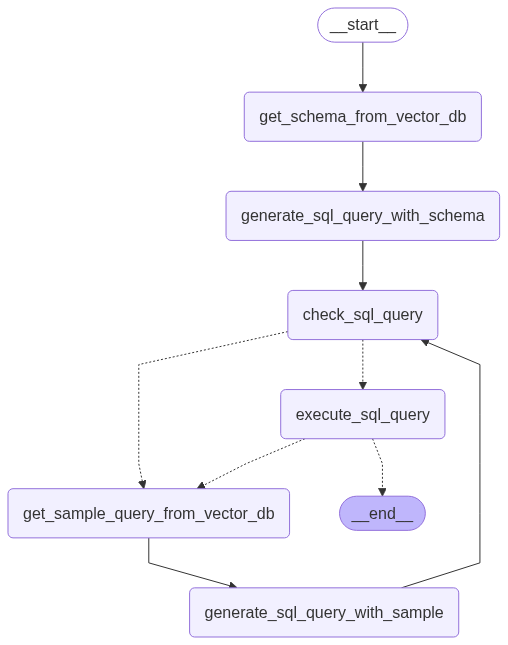

In [ ]:
text_to_sql_app

### 엑셀에 있는 질의를 한꺼번에 테스트 하고 엑셀에 다시 넣기

In [25]:
import query_withexcel

excel_file_path = "sample_50_postgresql.xlsx"  # 입력 엑셀 파일 경로
output_file_path = "sample_50_postgresql_result.xlsx"  # 출력 엑셀 파일 경로

# text_to_sql_app이 이미 정의되어 있다고 가정
# 실제 사용 시에는 여기서 앱을 초기화하거나 파라미터로 받아야 합니다.

print("Text2SQL 일괄 처리 시작...")
print(f"입력 파일: {excel_file_path}")
print(f"출력 파일: {output_file_path}")

# 일괄 처리 실행
query_withexcel.process_excel_batch(excel_file_path, text_to_sql_app, output_file_path)

Text2SQL 일괄 처리 시작...
입력 파일: sample_50_postgresql.xlsx
출력 파일: sample_50_postgresql_result.xlsx
엑셀 파일 로드 완료: 50 rows

[1/50] Processing NO: 1
Processing query: 시가총액 상위 30개 회사명과 시가총액을 알려주세요....
--- [TextToSql] Generating SQL for query with_schema: '시가총액 상위 30개 회사명과 시가총액을 알려주세요.' ---
t2s_llm response :  ```sql
    SELECT kor_name_small, market_cap
    FROM m_asset.exchange_kosdaq_stock_master
    ORDER BY market_cap DESC
    LIMIT 30;
    ``` 
 -----------------------------
Generated SQL (Attempt): SELECT kor_name_small, market_cap
    FROM m_asset.exchange_kosdaq_stock_master
    ORDER BY market_cap DESC
    LIMIT 30;
Query check raw result:  SELECT kor_name_small, market_cap
    FROM m_asset.exchange_kosdaq_stock_master
    ORDER BY market_cap DESC
    LIMIT 30;
Syntax check passed.
Decision: Syntax check passed, routing to execute_sql_query.
--- [TextToSql] Executing SQL query: SELECT kor_name_small, market_cap
    FROM m_asset.exchange_kosdaq_stock_master
    ORDER BY market_cap DESC
 

d:\GITLAB\m_asset\02_Market_Agent_poc\query_withexcel.py:120: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'SELECT s.kor_name_small AS 회사명, i.market_cap AS 시가총액
    FROM m_asset.exchange_kosdaq_stock_master s
    JOIN m_asset.industry_stock_mapping i ON s.stock_code = i.stock_code AND s.data_date = i.data_date
    ORDER BY i.market_cap DESC
    LIMIT 30;' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, '구문'] = result['final_query']
d:\GITLAB\m_asset\02_Market_Agent_poc\query_withexcel.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Passed.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, '구문O'] = result['syntax_check']
d:\GITLAB\m_asset\02_Market_Agent_poc\query_withexcel.py:122: FutureWarning: Setting an i

t2s_llm response :  ```sql
    SELECT 
        e.stock_code,
        e.kor_name_small AS 회사명,
        e.market_cap AS 시가총액,
        t.buy_volume + t.sell_volume AS 거래량,
        (t.buy_volume + t.sell_volume) / e.market_cap AS 시가총액_대비_거래량
    FROM 
        m_asset.exchange_kosdaq_stock_master e
    JOIN 
        m_asset.trade_status t ON e.stock_code = t.stock_code AND e.data_date = t.data_date
    WHERE 
        e.market_cap >= 5000000000000
    ORDER BY 
        (t.buy_volume + t.sell_volume) / e.market_cap DESC
    LIMIT 5;
    ``` 
 -----------------------------
Generated SQL (Attempt): SELECT 
        e.stock_code,
        e.kor_name_small AS 회사명,
        e.market_cap AS 시가총액,
        t.buy_volume + t.sell_volume AS 거래량,
        (t.buy_volume + t.sell_volume) / e.market_cap AS 시가총액_대비_거래량
    FROM 
        m_asset.exchange_kosdaq_stock_master e
    JOIN 
        m_asset.trade_status t ON e.stock_code = t.stock_code AND e.data_date = t.data_date
    WHERE 
        e.market_cap >= 50